In [2]:
import utils
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
# Load the Dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769


(2115, 22, 1000)


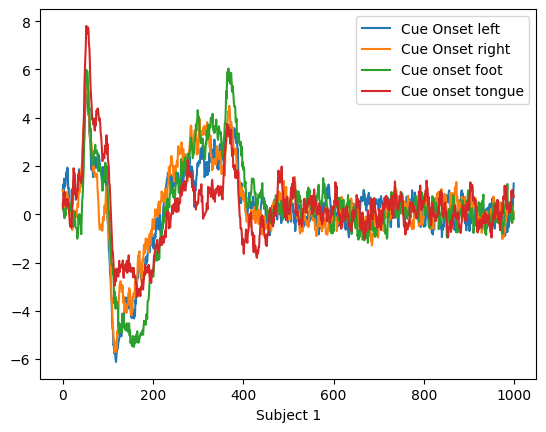

In [4]:
ch_data = X_train_valid[:,2,:]

class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.figure()
plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.xlabel("Subject {subject}".format(subject=1))

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

When observing the EEG data, it is evident that, even across all subjects, the data becomes very flatlined and noisy towards the end of the measured intervals. There is certainly an argument to be made that this data is not necessary - it might even adversely affect classifiers trained over the entire interval since we would like the classifier to "focus" on the more relevant subintervals of data, which is roughly between 0 and 600. To test this intuition, the we can train the model optimized in the previous notebook over various time intervals and determine whether there is an improvement by choosing certain intervals.

In [5]:
ind_valid = np.random.choice(2115, 200, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Shuffle the data after adding the noise to them so that the noisy examples 
# are not all together
x_train, y_train = utils.addNoisyExamplesToData(x_train, y_train, 5000, 0, 1)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
print(x_train.shape)
print(y_train.shape)

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

# Reshape so that each example is three-dimensional 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Axis swapping
x_train = np.swapaxes(x_train, 1, 3)
x_train = np.swapaxes(x_train, 1, 2)
x_valid = np.swapaxes(x_valid, 1, 3)
x_valid = np.swapaxes(x_valid, 1, 2)
X_test = np.swapaxes(X_test, 1, 3)
X_test = np.swapaxes(X_test, 1, 2)

print(x_train.shape)

(6915, 22, 1000)
(6915,)
(6915, 1000, 1, 22)


In [6]:
intervals = [200, 400, 600, 800, 1000]
models = []

for interval in intervals:
  time_interval_cnn_model = Sequential()

  # Given that this is time-series data, having a kernel that is more along one dimension (e.g. 15 by 1) is reasonable
  # since there is not really much of a relationship between "square" tiles of the data but rather subsequent 
  # tiles
  time_interval_cnn_model.add(Conv2D(filters=10, kernel_size=(15, 1), padding='same', activation='relu', input_shape=(interval, 1, 22)))
  time_interval_cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
  time_interval_cnn_model.add(BatchNormalization())
  time_interval_cnn_model.add(Dropout(0.5))

  time_interval_cnn_model.add(Conv2D(filters=20, kernel_size=(10, 1), padding='same', activation='relu'))
  time_interval_cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
  time_interval_cnn_model.add(BatchNormalization())
  time_interval_cnn_model.add(Dropout(0.5))

  time_interval_cnn_model.add(Conv2D(filters=40, kernel_size=(5, 1), padding='same', activation='relu'))
  time_interval_cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
  time_interval_cnn_model.add(BatchNormalization())
  time_interval_cnn_model.add(Dropout(0.5))

  time_interval_cnn_model.add(Conv2D(filters=60, kernel_size=(5, 1), padding='same', activation='relu'))
  time_interval_cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
  time_interval_cnn_model.add(BatchNormalization())
  time_interval_cnn_model.add(Dropout(0.5))


  time_interval_cnn_model.add(Flatten())
  time_interval_cnn_model.add(Dense(4, activation='softmax'))

  models.append(time_interval_cnn_model)


In [7]:
# The goal here is to train 5 different models just to compare how well they perform relative to 
# each other, so there is no need to train each fully - 50 epochs each should suffice

learning_rate = 1e-3
epochs = 50 
cnn_model_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [8]:
results = []
for i in range(len(models)):
  model = models[i]
  model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_model_optimizer,
                 metrics=['accuracy'])
  
  result = model.fit(x_train[:, 0:intervals[i],:,:],
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid[:, 0:intervals[i],:,:], y_valid), verbose=True)
  
  results.append(result)

Epoch 1/50
109/109 [==============================] - 2s 14ms/step - loss: 2.0414 - accuracy: 0.2571 - val_loss: 1.3716 - val_accuracy: 0.3200
Epoch 2/50
109/109 [==============================] - 2s 14ms/step - loss: 1.6812 - accuracy: 0.2794 - val_loss: 1.3688 - val_accuracy: 0.3100
Epoch 3/50
109/109 [==============================] - 1s 13ms/step - loss: 1.5286 - accuracy: 0.2852 - val_loss: 1.3530 - val_accuracy: 0.3150
Epoch 4/50
109/109 [==============================] - 1s 13ms/step - loss: 1.4322 - accuracy: 0.3076 - val_loss: 1.3467 - val_accuracy: 0.3050
Epoch 5/50
109/109 [==============================] - 2s 15ms/step - loss: 1.4050 - accuracy: 0.3108 - val_loss: 1.3437 - val_accuracy: 0.3450
Epoch 6/50
109/109 [==============================] - 2s 14ms/step - loss: 1.3726 - accuracy: 0.3275 - val_loss: 1.3640 - val_accuracy: 0.3450
Epoch 7/50
109/109 [==============================] - 2s 16ms/step - loss: 1.3545 - accuracy: 0.3378 - val_loss: 1.3618 - val_accuracy: 0.3500

In [9]:
test_accuracies = []
for i in range(len(models)):
  model = models[i]
  res = model.evaluate(X_test[:, 0:intervals[i], :, :], y_test, verbose=False)
  test_accuracies.append(res[1])
  print("Testing Accuracy for Model Over 0-{interval}: {accuracy}".format(interval=intervals[i], accuracy=res[1]))


Testing Accuracy for Model Over 0-200: 0.5914221405982971
Testing Accuracy for Model Over 0-400: 0.6613995432853699
Testing Accuracy for Model Over 0-600: 0.6478555202484131
Testing Accuracy for Model Over 0-800: 0.6049661636352539
Testing Accuracy for Model Over 0-1000: 0.6297968626022339


Text(0, 0.5, 'Testing Accuracy')

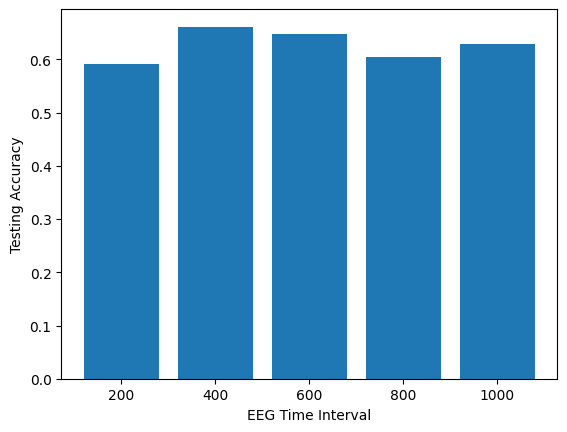

In [10]:
plt.figure()
plt.bar(["200", "400", "600", "800", "1000"], test_accuracies)
plt.xlabel("EEG Time Interval")
plt.ylabel("Testing Accuracy")

From this experiment, it is indeed the case that some time intervals perform better than others. Particularly, the intervals from 0-400 and 0-600 performed the best. This suggests that it would be beneficial to train the model over a smaller time interval, say 0-600 (as 600 is roughly where the data becomes flat and noisy over all subjects), as not only would it allow for better performance, but it would also allow for easier training since there is less overall data needed to be worked with.

In [14]:
time_interval_cnn_model = Sequential()

# Given that this is time-series data, having a kernel that is more along one dimension (e.g. 15 by 1) is reasonable
# since there is not really much of a relationship between "square" tiles of the data but rather subsequent 
# tiles
time_interval_cnn_model.add(Conv2D(filters=10, kernel_size=(15, 1), padding='same', activation='relu', input_shape=(600, 1, 22)))
time_interval_cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
time_interval_cnn_model.add(BatchNormalization())
time_interval_cnn_model.add(Dropout(0.5))

time_interval_cnn_model.add(Conv2D(filters=20, kernel_size=(10, 1), padding='same', activation='relu'))
time_interval_cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
time_interval_cnn_model.add(BatchNormalization())
time_interval_cnn_model.add(Dropout(0.5))

time_interval_cnn_model.add(Conv2D(filters=40, kernel_size=(5, 1), padding='same', activation='relu'))
time_interval_cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
time_interval_cnn_model.add(BatchNormalization())
time_interval_cnn_model.add(Dropout(0.5))

time_interval_cnn_model.add(Conv2D(filters=60, kernel_size=(5, 1), padding='same', activation='relu'))
time_interval_cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
time_interval_cnn_model.add(BatchNormalization())
time_interval_cnn_model.add(Dropout(0.5))


time_interval_cnn_model.add(Flatten())
time_interval_cnn_model.add(Dense(4, activation='softmax'))

In [15]:
learning_rate = 1e-3
epochs = 250
cnn_model_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [16]:
time_interval_cnn_model.compile(loss='categorical_crossentropy',
                optimizer=cnn_model_optimizer,
                metrics=['accuracy'])

result = time_interval_cnn_model.fit(x_train[:, 0:600,:,:],
            y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid[:, 0:600,:,:], y_valid), verbose=True)


Epoch 1/250
109/109 [==============================] - 3s 28ms/step - loss: 1.9914 - accuracy: 0.2681 - val_loss: 1.3702 - val_accuracy: 0.3200
Epoch 2/250
109/109 [==============================] - 3s 28ms/step - loss: 1.6359 - accuracy: 0.2967 - val_loss: 1.3617 - val_accuracy: 0.3250
Epoch 3/250
109/109 [==============================] - 3s 29ms/step - loss: 1.5099 - accuracy: 0.3131 - val_loss: 1.3497 - val_accuracy: 0.3050
Epoch 4/250
109/109 [==============================] - 3s 29ms/step - loss: 1.4165 - accuracy: 0.3343 - val_loss: 1.3436 - val_accuracy: 0.3150
Epoch 5/250
109/109 [==============================] - 3s 29ms/step - loss: 1.3677 - accuracy: 0.3578 - val_loss: 1.3640 - val_accuracy: 0.2850
Epoch 6/250
109/109 [==============================] - 3s 29ms/step - loss: 1.3232 - accuracy: 0.3735 - val_loss: 1.3464 - val_accuracy: 0.3100
Epoch 7/250
109/109 [==============================] - 3s 29ms/step - loss: 1.2696 - accuracy: 0.4133 - val_loss: 1.3735 - val_accuracy:

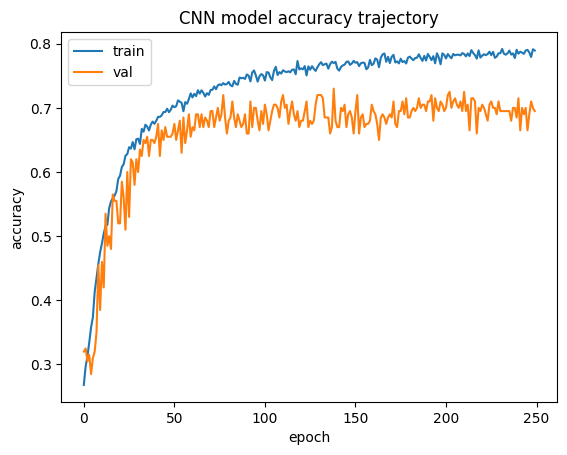

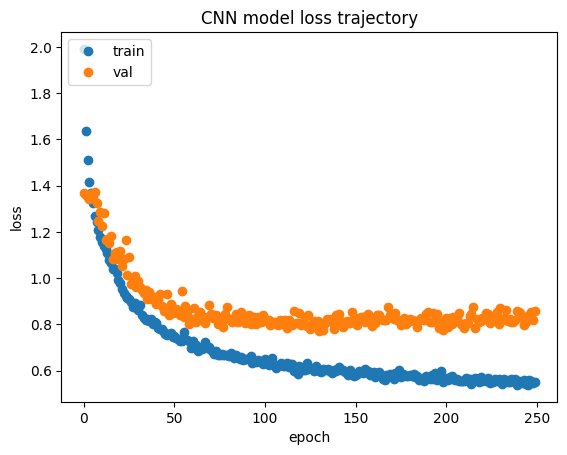

In [17]:
# Plotting accuracy trajectory
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(result.history['loss'],'o')
plt.plot(result.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
cnn_model_score_all_subjects = time_interval_cnn_model.evaluate(X_test[:, 0:600, :, :], y_test, verbose=0)
print("Accuracy Across All Subjects: {score}".format(score=cnn_model_score_all_subjects[1]))

Accuracy Across All Subjects: 0.6839728951454163


Although the accuracy is slightly lower than the previous model, it can be argued that this is due to the randomness associated with training. What is more significant is, comparing the loss trajectory and validation accuracy of this trimmed model with the full model trained in the previous notebook, this trimmed model was able to converge *much faster* than the previous model with respect to computation time. Each epoch in the previous model took roughly six and a half seconds whereas each epoch in this model took roughly four seconds. This is a noticeable speedup which can make training subsequent models much more fast if done on the trimmed data since it is known that the accuracy will be roughly similar.